# Import packages

In [1]:
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import json
import numpy as np
import re 
from matplotlib import pyplot as plt
import seaborn as sns


sns.set_theme(style="darkgrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 30)

# Web scraping

In [2]:
def get_content(td):
    '''this function will deal with situation when there is a list inside <td> </td>'''
    if td.find('li'):
        return ', '.join((li.get_text(' ', strip=True).replace('\xa0', ' ') for li in td.find_all('li'))) 
    else:
        return td.get_text(' ', strip=True).replace('\xa0', ' ')

def get_imdb(title):
    '''get imdb information by movie title'''
    base_url = 'http://www.omdbapi.com/'
    api_key = '&apikey=a897ec22'
    title = title.replace(' ', '+')
    title = '?t=' + title
    r = requests.get(base_url + title + api_key).json()
    return r.get('imdbRating', None), r.get('imdbVotes', None), r.get('Rated', None)


def movie_page_scrapping(url):
    '''scrape wikipedia movie page'''
    # Set connection with wikipedia page using url
    web_page = requests.get(url)
    # Convert the connection object into beatiful soup object
    movie_page = bs(web_page.content) 
    # Get movie infobox 
    infobox = movie_page.find(class_='infobox vevent')
    # Get all table rows in the infobox
    infobox_rows = infobox.find_all('tr')
    # Single movie content dictionary
    movie_content = dict() 
    for index, row in enumerate(infobox_rows):
        # Everything except movie poster and movie title
        if index > 1: 
            infobox_row_title = row.find('th').get_text(' ', strip=True)
            infobox_row_value = get_content(row.find('td'))
            movie_content[infobox_row_title] = infobox_row_value
        # Movie poster (image)
        elif index == 1:
            continue
        # Movie title
        else:
            title = row.find('th').get_text(' ', strip=True)
            movie_content['title'] = title
    # Add imdb information in the movie dictionary
    movie_content['imdbRating'], movie_content['imdbVotes'], movie_content['Rated'] = get_imdb(title)
    return movie_content


In [3]:
# Set connection to web page where all disney movies are listed
web_page = requests.get(r'https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films')
web_page = bs(web_page.content)
# Get infoboxes which contain list of movies by decades and use slice(:-3) to exclude upcoming/undated/in_development infoboxes 
movies_infoboxes: list = web_page.select('.wikitable.sortable')[:-3]
# Transmute infoboxes into list of rows from the infobox
infoboxes_transmuted = (infobox.find_all('i') for infobox in movies_infoboxes)

# List of movie content dictionaries
movies_list = []
# Select each infobox list
for infobox in infoboxes_transmuted: 
    # Select every single row from the infobox, row example: <i><a href="/wiki/Snow_White_and_the_Seven_Dwarfs_(1937_film)" title="Snow White and the Seven Dwarfs (1937 film)">Snow White and the Seven Dwarfs</a></i>
    for row in infobox: 
        try:
            # Make a valid url
            url = 'https://en.wikipedia.org' + row.a['href']
            # Perform movie page scrapping
            movies_list.append(movie_page_scrapping(url))
        except (TypeError, AttributeError):
            continue   

### Web scraping process approximately takes 12 minutes. <br> I have saved the results of web scraping into json file to eliminate the need of rerunning this process over and over again.

In [4]:
# Save list of movie content dictionaries into json
# with open('disney_wikipedia.json', 'w') as file:
#     json.dump(movies_list, file)    

# Data transformation and exploring

In [6]:
# Load web-scrapped dataset
df = pd.read_json(r'C:\Users\MyProfileAdministrator\Desktop\programming\Projects\disney_wikipedia.json')
df.head(5)

,title,Directed by,Story by,Based on,Produced by,Starring,Music by,Production company,Distributed by,Release dates,Running time,Country,Language,Budget,Box office,imdbRating,imdbVotes,Rated,Narrated by,Cinematography,Release date,Written by,Edited by,Languages,Screenplay by,Countries,Color process,Production companies,Layouts by
0,Snow White and the Seven D...,"David Hand, Perce Pearce, ...","Ted Sears, Richard Creedon...",Snow White by the Brothers...,Walt Disney,"Adriana Caselotti, Roy Atw...","Frank Churchill, Leigh Har...",Walt Disney Productions,RKO Radio Pictures,"December 21, 1937 ( 1937-1...",83 minutes,United States,English,$1.5 million [1],$418 million [2],7.6,"209,330",Approved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pinocchio,"Ben Sharpsteen, Hamilton L...","Ted Sears, Otto Englander,...",The Adventures of Pinocchi...,Walt Disney,"Cliff Edwards, Dickie Jone...","Leigh Harline, Paul J. Smith",Walt Disney Productions,RKO Radio Pictures Buena V...,"February 7, 1940 ( 1940-02...",88 minutes,United States,English,$2.6 million [3],$164 million,7.5,"154,739",G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fantasia,"Samuel Armstrong, James Al...","Joe Grant, Dick Huemer",NaN,"Walt Disney, Ben Sharpsteen","Leopold Stokowski, Deems T...",See program,Walt Disney Productions,RKO Radio Pictures,NaN,126 minutes [1],United States,English,$2.28 million [2] [3],$76.4–$83.3 million (Unite...,7.7,"100,976",G,Deems Taylor,James Wong Howe,"November 13, 1940 ( 1940-1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The Reluctant Dragon,Alfred Werker (live action...,NaN,NaN,Walt Disney,Robert Benchley Frances Gi...,Frank Churchill Larry Morey,Walt Disney Productions,RKO Radio Pictures,NaN,74 minutes,United States,English,"$600,000 [2]","$960,000 (worldwide rental...",6.8,"3,626",Approved,NaN,Bert Glennon,"June 27, 1941 ( 1941-06-27...",Live-action: Ted Sears Al ...,Paul Weatherwax,NaN,NaN,NaN,NaN,NaN,NaN
4,Dumbo,"Ben Sharpsteen, Norman Fer...","Joe Grant, Dick Huemer","Dumbo, the Flying Elephant...",Walt Disney,"Edward Brophy, Verna Felto...",Frank Churchill Oliver Wal...,Walt Disney Productions,RKO Radio Pictures,"October 23, 1941 ( 1941-10...",64 minutes,United States,English,"$950,000 [2]",>$1.3 million (est. United...,7.2,"137,766",G,John McLeish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# check for missing values
df.isna().sum()

title                     0
Directed by               2
Story by                348
Based on                233
Produced by               9
Starring                 32
Music by                  2
Production company      305
Distributed by            0
Release dates           318
Running time              3
Country                  67
Language                 22
Budget                  202
Box office              119
imdbRating               21
imdbVotes                21
Rated                    21
Narrated by             451
Cinematography          123
Release date            193
Written by              293
Edited by                36
Languages               489
Screenplay by           259
Countries               448
Color process           504
Production companies    206
Layouts by              509
dtype: int64

In [8]:
# There are columns with the same information but differently named
# So i would like to combine 2 identical columns into single one 
# Define the function which is going to grab information from column2 and deliver it into column1
def replace_column_values_ifna(column1: str, column2: str):
    '''replace missing values in column1 with corresponding values from column2'''
    df[column1] = df.apply(lambda x: x[column2] if x[column1] is np.nan else x[column1], axis=1)

# Make transformations using function defined earlier
replace_column_values_ifna('Country', 'Countries')
replace_column_values_ifna('Language', 'Languages')
replace_column_values_ifna('Release dates', 'Release date')

df.head(5)

,title,Directed by,Story by,Based on,Produced by,Starring,Music by,Production company,Distributed by,Release dates,Running time,Country,Language,Budget,Box office,imdbRating,imdbVotes,Rated,Narrated by,Cinematography,Release date,Written by,Edited by,Languages,Screenplay by,Countries,Color process,Production companies,Layouts by
0,Snow White and the Seven D...,"David Hand, Perce Pearce, ...","Ted Sears, Richard Creedon...",Snow White by the Brothers...,Walt Disney,"Adriana Caselotti, Roy Atw...","Frank Churchill, Leigh Har...",Walt Disney Productions,RKO Radio Pictures,"December 21, 1937 ( 1937-1...",83 minutes,United States,English,$1.5 million [1],$418 million [2],7.6,"209,330",Approved,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pinocchio,"Ben Sharpsteen, Hamilton L...","Ted Sears, Otto Englander,...",The Adventures of Pinocchi...,Walt Disney,"Cliff Edwards, Dickie Jone...","Leigh Harline, Paul J. Smith",Walt Disney Productions,RKO Radio Pictures Buena V...,"February 7, 1940 ( 1940-02...",88 minutes,United States,English,$2.6 million [3],$164 million,7.5,"154,739",G,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fantasia,"Samuel Armstrong, James Al...","Joe Grant, Dick Huemer",NaN,"Walt Disney, Ben Sharpsteen","Leopold Stokowski, Deems T...",See program,Walt Disney Productions,RKO Radio Pictures,"November 13, 1940 ( 1940-1...",126 minutes [1],United States,English,$2.28 million [2] [3],$76.4–$83.3 million (Unite...,7.7,"100,976",G,Deems Taylor,James Wong Howe,"November 13, 1940 ( 1940-1...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The Reluctant Dragon,Alfred Werker (live action...,NaN,NaN,Walt Disney,Robert Benchley Frances Gi...,Frank Churchill Larry Morey,Walt Disney Productions,RKO Radio Pictures,"June 27, 1941 ( 1941-06-27...",74 minutes,United States,English,"$600,000 [2]","$960,000 (worldwide rental...",6.8,"3,626",Approved,NaN,Bert Glennon,"June 27, 1941 ( 1941-06-27...",Live-action: Ted Sears Al ...,Paul Weatherwax,NaN,NaN,NaN,NaN,NaN,NaN
4,Dumbo,"Ben Sharpsteen, Norman Fer...","Joe Grant, Dick Huemer","Dumbo, the Flying Elephant...",Walt Disney,"Edward Brophy, Verna Felto...",Frank Churchill Oliver Wal...,Walt Disney Productions,RKO Radio Pictures,"October 23, 1941 ( 1941-10...",64 minutes,United States,English,"$950,000 [2]",>$1.3 million (est. United...,7.2,"137,766",G,John McLeish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# get rid of useless columns
df = df.loc[:, ['title', 'Release dates', 'Running time', 'Country', 'Language', 'Budget',
       'Box office', 'imdbRating', 'imdbVotes', 'Rated']]
df.head()

,title,Release dates,Running time,Country,Language,Budget,Box office,imdbRating,imdbVotes,Rated
0,Snow White and the Seven D...,"December 21, 1937 ( 1937-1...",83 minutes,United States,English,$1.5 million [1],$418 million [2],7.6,"209,330",Approved
1,Pinocchio,"February 7, 1940 ( 1940-02...",88 minutes,United States,English,$2.6 million [3],$164 million,7.5,"154,739",G
2,Fantasia,"November 13, 1940 ( 1940-1...",126 minutes [1],United States,English,$2.28 million [2] [3],$76.4–$83.3 million (Unite...,7.7,"100,976",G
3,The Reluctant Dragon,"June 27, 1941 ( 1941-06-27...",74 minutes,United States,English,"$600,000 [2]","$960,000 (worldwide rental...",6.8,"3,626",Approved
4,Dumbo,"October 23, 1941 ( 1941-10...",64 minutes,United States,English,"$950,000 [2]",>$1.3 million (est. United...,7.2,"137,766",G


In [10]:
# Check for missing values one more time to make sure that missing values were replenished
df.isna().sum()

title              0
Release dates      0
Running time       3
Country            4
Language           0
Budget           202
Box office       119
imdbRating        21
imdbVotes         21
Rated             21
dtype: int64

In [11]:
# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          511 non-null    object
 1   Release dates  511 non-null    object
 2   Running time   508 non-null    object
 3   Country        507 non-null    object
 4   Language       511 non-null    object
 5   Budget         309 non-null    object
 6   Box office     392 non-null    object
 7   imdbRating     490 non-null    object
 8   imdbVotes      490 non-null    object
 9   Rated          490 non-null    object
dtypes: object(10)
memory usage: 40.0+ KB


In [12]:
# Gather descriptive statistics about the data
df.describe()

,title,Release dates,Running time,Country,Language,Budget,Box office,imdbRating,imdbVotes,Rated
count,511,511,508,507,511,309,392,490,490,490
unique,496,510,204,50,27,242,387,53,465,13
top,Freaky Friday,"October 18, 1967 ( 1967-10...",93 minutes,United States,English,$5 million [1],$1.025 billion [5],6.4,445,G
freq,2,2,15,398,472,7,2,29,2,196


In [13]:
# Check for duplicates
df.duplicated().sum()

0

## Clean up inconsistencies in Country, Language and Running time columns

In [14]:
# Display these 3 columns
df.loc[:, ['Country', 'Language', 'Running time']].head(25)

,Country,Language,Running time
0,United States,English,83 minutes
1,United States,English,88 minutes
2,United States,English,126 minutes [1]
3,United States,English,74 minutes
4,United States,English,64 minutes
5,United States,English,70 minutes
6,United States,"English, Portuguese, Spanish",42 minutes
7,United States,English,65 min
8,United States,"English, Spanish, Portuguese",71 minutes
9,United States,English,75 minutes


In [15]:
# Define the function which is going to split column values by listed symbols and always keep first value
def split(column: str, symbols: list = ['[', '(', ',']):
    '''split by listed symbols and keep first value, 
       For example: input - English, ([Russian, Hindi])
                    output - English'''
    for symbol in symbols:
        df[column] = df[column].str.split(symbol).str[0].str.strip()

# Make transformations using this function
split('Country')
split('Language')
split('Running time', symbols=[' '])

# Make sure that changes were applied to df
df.loc[:, ['Country', 'Language', 'Running time']].head(10)

,Country,Language,Running time
0,United States,English,83
1,United States,English,88
2,United States,English,126
3,United States,English,74
4,United States,English,64
5,United States,English,70
6,United States,English,42
7,United States,English,65
8,United States,English,71
9,United States,English,75


## Replace missing values with mean value in Running Time column

In [16]:
df['Running time'].isna().sum()

3

In [17]:
# Fill in the missing values with 0
df['Running time'] = df['Running time'].fillna('0')

# Change datatype 
df['Running time'] = df['Running time'].astype(int)

# Calculate the mean 
rt_mean = int(df['Running time'].mean())

# Replace all missing values with mean value
df['Running time'] = df['Running time'].replace(0, rt_mean)

# Make sure the changes were applied
df['Running time'].isna().sum()

0

## Replace missing values in Country column

In [18]:
# Check for missing values in the column
df['Country'].isna().sum()

4

In [19]:
# Check the distribution of Countries
df['Country'].value_counts()


Country
United States                           443
United Kingdom United States             12
United States Canada                      9
India                                     7
United States Australia                   4
Russia                                    4
United States United Kingdom              4
Australia                                 3
France                                    3
United States France United Kingdom       2
Germany                                   2
Canada                                    2
United Kingdom                            2
India United States                       1
France United States                      1
United States Canada Australia            1
United States United Kingdom Germany      1
Japan                                     1
United States France                      1
United States Austria                     1
Norway Sweden United States               1
United States Mexico                      1
United States Greece    

In [20]:
# There is majority of 'United States' values so i decided to fill in the missing values using backfill method because it won't make any serious difference in results
df['Country'] = df['Country'].fillna(method='bfill')

# Make sure missing values are gone
df['Country'].isna().sum()

0

## Clean up values in Budget and Box office columns

In [21]:
# Define a dictionary with pairs of numbers in text: digit formats
dic = {'million': 1000000, 
    'billion': 1000000000}

def transform(x: str):
    '''transform "121 million" like values into numeric'''
    x = re.findall(r'\d+\.?\d*\s?(?:thousand|million|billion)?', x)
    # If regular expression found something
    if x:
        # It might be a situation when regex will find 2 values, so x[-1] statement obligates to take the second which is the highest value from both
        x = x[-1]
        # Deals with situations when value format is like '196.5 million'
        try:
            # split '196.5 million' by space into 2 separate variables: first = 196.5, second = million
            first, second = x.split(' ')
            # convert 'million' into digit format and multiplicate it with 196.5
            return int(float(first) * dic[second])
        # If an error occured it indicates that the value in plain digit format like '200' without string additions
        except (KeyError, ValueError):
            # Strip spaces from value and return it
            return x.strip()
    # If nothing was found return 0
    return '0'

# Define the function which is going to clean up inconsistent values and then apply the transform function
def money_to_numeric(column_name: str):
    df[column_name] = df[column_name].str.split('[').str[0].str.replace(',', '')
    df[column_name] = df[column_name].str.extract(r'((?:\d+.*\d+|\d+) (?:thousand|million|billion)?)')
    df[column_name] = df[column_name].fillna('0').str.replace('$', '').str.strip()
    df[column_name] = df[column_name].apply(transform)
    return None



In [22]:
# Apply the function to the columns
money_to_numeric('Budget')
money_to_numeric('Box office')

In [23]:
# Make sure the changes are applied to the columns
df.loc[:, ['Budget', 'Box office']].head(10)

,Budget,Box office
0,1500000,418000000
1,2600000,164000000
2,2280000,83300000
3,600000,960000
4,950000,1300000
5,858000,267399999
6,0,1000000
7,0,0
8,0,3355000
9,1350000,3275000


## Change string data values into the datetime format

In [24]:
# In the Release dates column the dates are in two different formats, i'm going to make a copy of this column and apply different formats to different columns when transforming

# Make a copy of the Release dates column
df['dates_copy'] = df['Release dates'].copy()

# Extract datetime using the first datetime format
df['Release dates'] = df['Release dates'].str.extract(r'(\w+ \d+, \d+)')
df['Release dates'] = pd.to_datetime(df['Release dates'], format='%B %d, %Y', errors='coerce')

# Extract datetime using the second datetime format
df['dates_copy'] = df['dates_copy'].str.extract(r'(\d+ \w+ \d+)')
df['dates_copy'] = pd.to_datetime(df['dates_copy'], format='%d %B %Y', errors='coerce')

In [25]:
# Check what happened to out date columns
df[['Release dates', 'dates_copy']].iloc[15:25]

,Release dates,dates_copy
15,1950-02-15,NaT
16,1950-06-22,NaT
17,1951-07-26,NaT
18,NaT,1952-03-13
19,1953-02-05,NaT
20,1953-07-23,NaT
21,1953-11-10,NaT
22,NaT,1953-10-26
23,1954-08-17,NaT
24,1954-12-23,NaT


In [26]:
# Fill themissing values in Release dates column with corresponding values from dates copy
df['Release dates'] = df.apply(lambda x: x['dates_copy'] if x['Release dates'] is pd.NaT else x['Release dates'], axis=1)

# Drop copied column 
del df['dates_copy']

# Make sure the changes were applied
df['Release dates'].iloc[15:25]

15   1950-02-15
16   1950-06-22
17   1951-07-26
18   1952-03-13
19   1953-02-05
20   1953-07-23
21   1953-11-10
22   1953-10-26
23   1954-08-17
24   1954-12-23
Name: Release dates, dtype: datetime64[ns]

In [27]:
# Check for missing values 
df['Release dates'].isna().sum()

3

In [28]:
# I decided to exclude these missing values from the dataset 
df = df[~df['Release dates'].isna()]
df['Release dates'].isna().sum()

0

## Fill in missing values in the imdbVotes, imdbRating and Rated columns

In [29]:
# Make some cleaning steps to imdbVotes column
df['imdbVotes'] = df['imdbVotes'].str.replace(',', '').str.replace('N/A', '0')

# Fill in missing values with '0' in imdbVotes column
df['imdbVotes'] = df['imdbVotes'].fillna('0')

# Fill in missing values with '0' in imdbRating column
df['imdbRating'] = df['imdbRating'].fillna('0').str.replace('N/A', '0')

# Fill in missing values with 'Unrated' in Rated column
df['Rated'] = df['Rated'].fillna('Unrated').str.replace('N/A', 'Unrated').str.replace('Not Rated', 'Unrated')

# Check missing values in these columns
df[['imdbVotes', 'imdbRating', 'Rated']].isna().sum()

imdbVotes     0
imdbRating    0
Rated         0
dtype: int64

## Make some other data transformation steps

In [30]:
# Rename dataframe columns
df.columns = ['Title', 'Released', 'Running_time', 'Country', 'Language', 'Budget', 'Box_office', 'imdbRating', 'imdbVotes', 'Rated']

In [31]:
# Convert dtypes 
df = df.astype({'Title':str, 'Released':'datetime64[ns]', 'Running_time':int, 'Country':str, 'Language':str, 'Budget':float, 'Box_office':float, 'imdbRating':float, 'imdbVotes':int, 'Rated':str})

# Check columns datatypes
df.dtypes

Title                   object
Released        datetime64[ns]
Running_time             int64
Country                 object
Language                object
Budget                 float64
Box_office             float64
imdbRating             float64
imdbVotes                int64
Rated                   object
dtype: object

In [32]:
# Change money values back to format displaying how many millions are there in the value
df['Budget'] = df['Budget'] / 1000000
df['Box_office'] = df['Box_office'] / 1000000

In [33]:
df.isna().sum()

Title           0
Released        0
Running_time    0
Country         0
Language        0
Budget          0
Box_office      0
imdbRating      0
imdbVotes       0
Rated           0
dtype: int64

In [34]:
df.describe()

,Released,Running_time,Budget,Box_office,imdbRating,imdbVotes
count,508,508.000000,508.000000,508.000000,508.000000,5.080000e+02
mean,1994-06-02 01:19:22.204724352,95.759843,44.398451,134.730802,6.150394,9.240788e+04
min,1937-12-21 00:00:00,40.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1976-12-16 18:00:00,82.000000,0.000000,0.000074,5.700000,1.927250e+03
50%,2000-09-24 00:00:00,95.000000,6.000000,18.603746,6.450000,1.517600e+04
75%,2010-11-18 00:00:00,106.000000,47.750000,134.475000,7.100000,1.014675e+05
max,2023-07-15 00:00:00,169.000000,650.000000,2196.000000,8.800000,1.168644e+06
std,NaN,19.320646,77.727995,276.716179,1.648913,1.843883e+05


In [35]:
# Display final dataset
df.head(10)

,Title,Released,Running_time,Country,Language,Budget,Box_office,imdbRating,imdbVotes,Rated
0,Snow White and the Seven D...,1937-12-21,83,United States,English,1.500,418.000000,7.6,209330,Approved
1,Pinocchio,1940-02-07,88,United States,English,2.600,164.000000,7.5,154739,G
2,Fantasia,1940-11-13,126,United States,English,2.280,83.300000,7.7,100976,G
3,The Reluctant Dragon,1941-06-27,74,United States,English,0.600,0.960000,6.8,3626,Approved
4,Dumbo,1941-10-23,64,United States,English,0.950,1.300000,7.2,137766,G
5,Bambi,1942-08-09,70,United States,English,0.858,267.399999,7.3,149446,G
6,Saludos Amigos,1942-08-24,42,United States,English,0.000,1.000000,6.0,7464,Passed
7,Victory Through Air Power,1943-07-17,65,United States,English,0.000,0.000000,6.5,1126,Unrated
8,The Three Caballeros,1944-12-21,71,United States,English,0.000,3.355000,6.3,14995,Approved
9,Make Mine Music,1946-04-20,75,United States,English,1.350,3.275000,6.2,4718,Passed


# Data vizualizations

In [36]:
# Exclude all zero values in Budget and Box office columns
viz = df.query("Budget > 0 and Box_office > 0")

### Check Budget and Box office columns for outliers

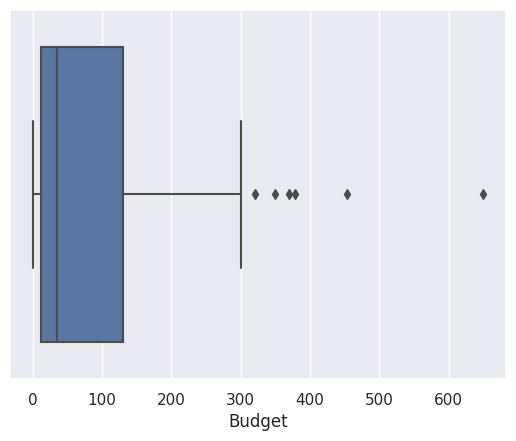

In [37]:
sns.boxplot(data=viz, x='Budget', orient='h')
plt.show()

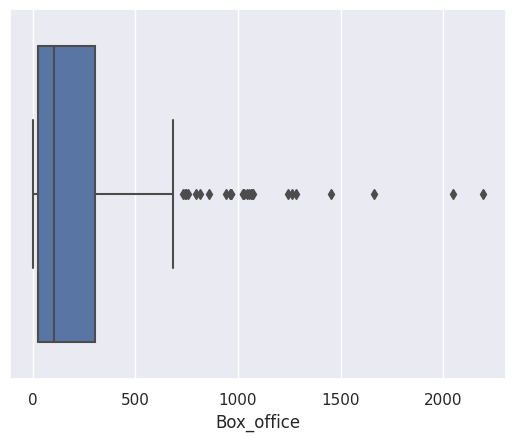

In [38]:
sns.boxplot(data=viz, x='Box_office', orient='h')
plt.show()

## Display Budget and Box office by years

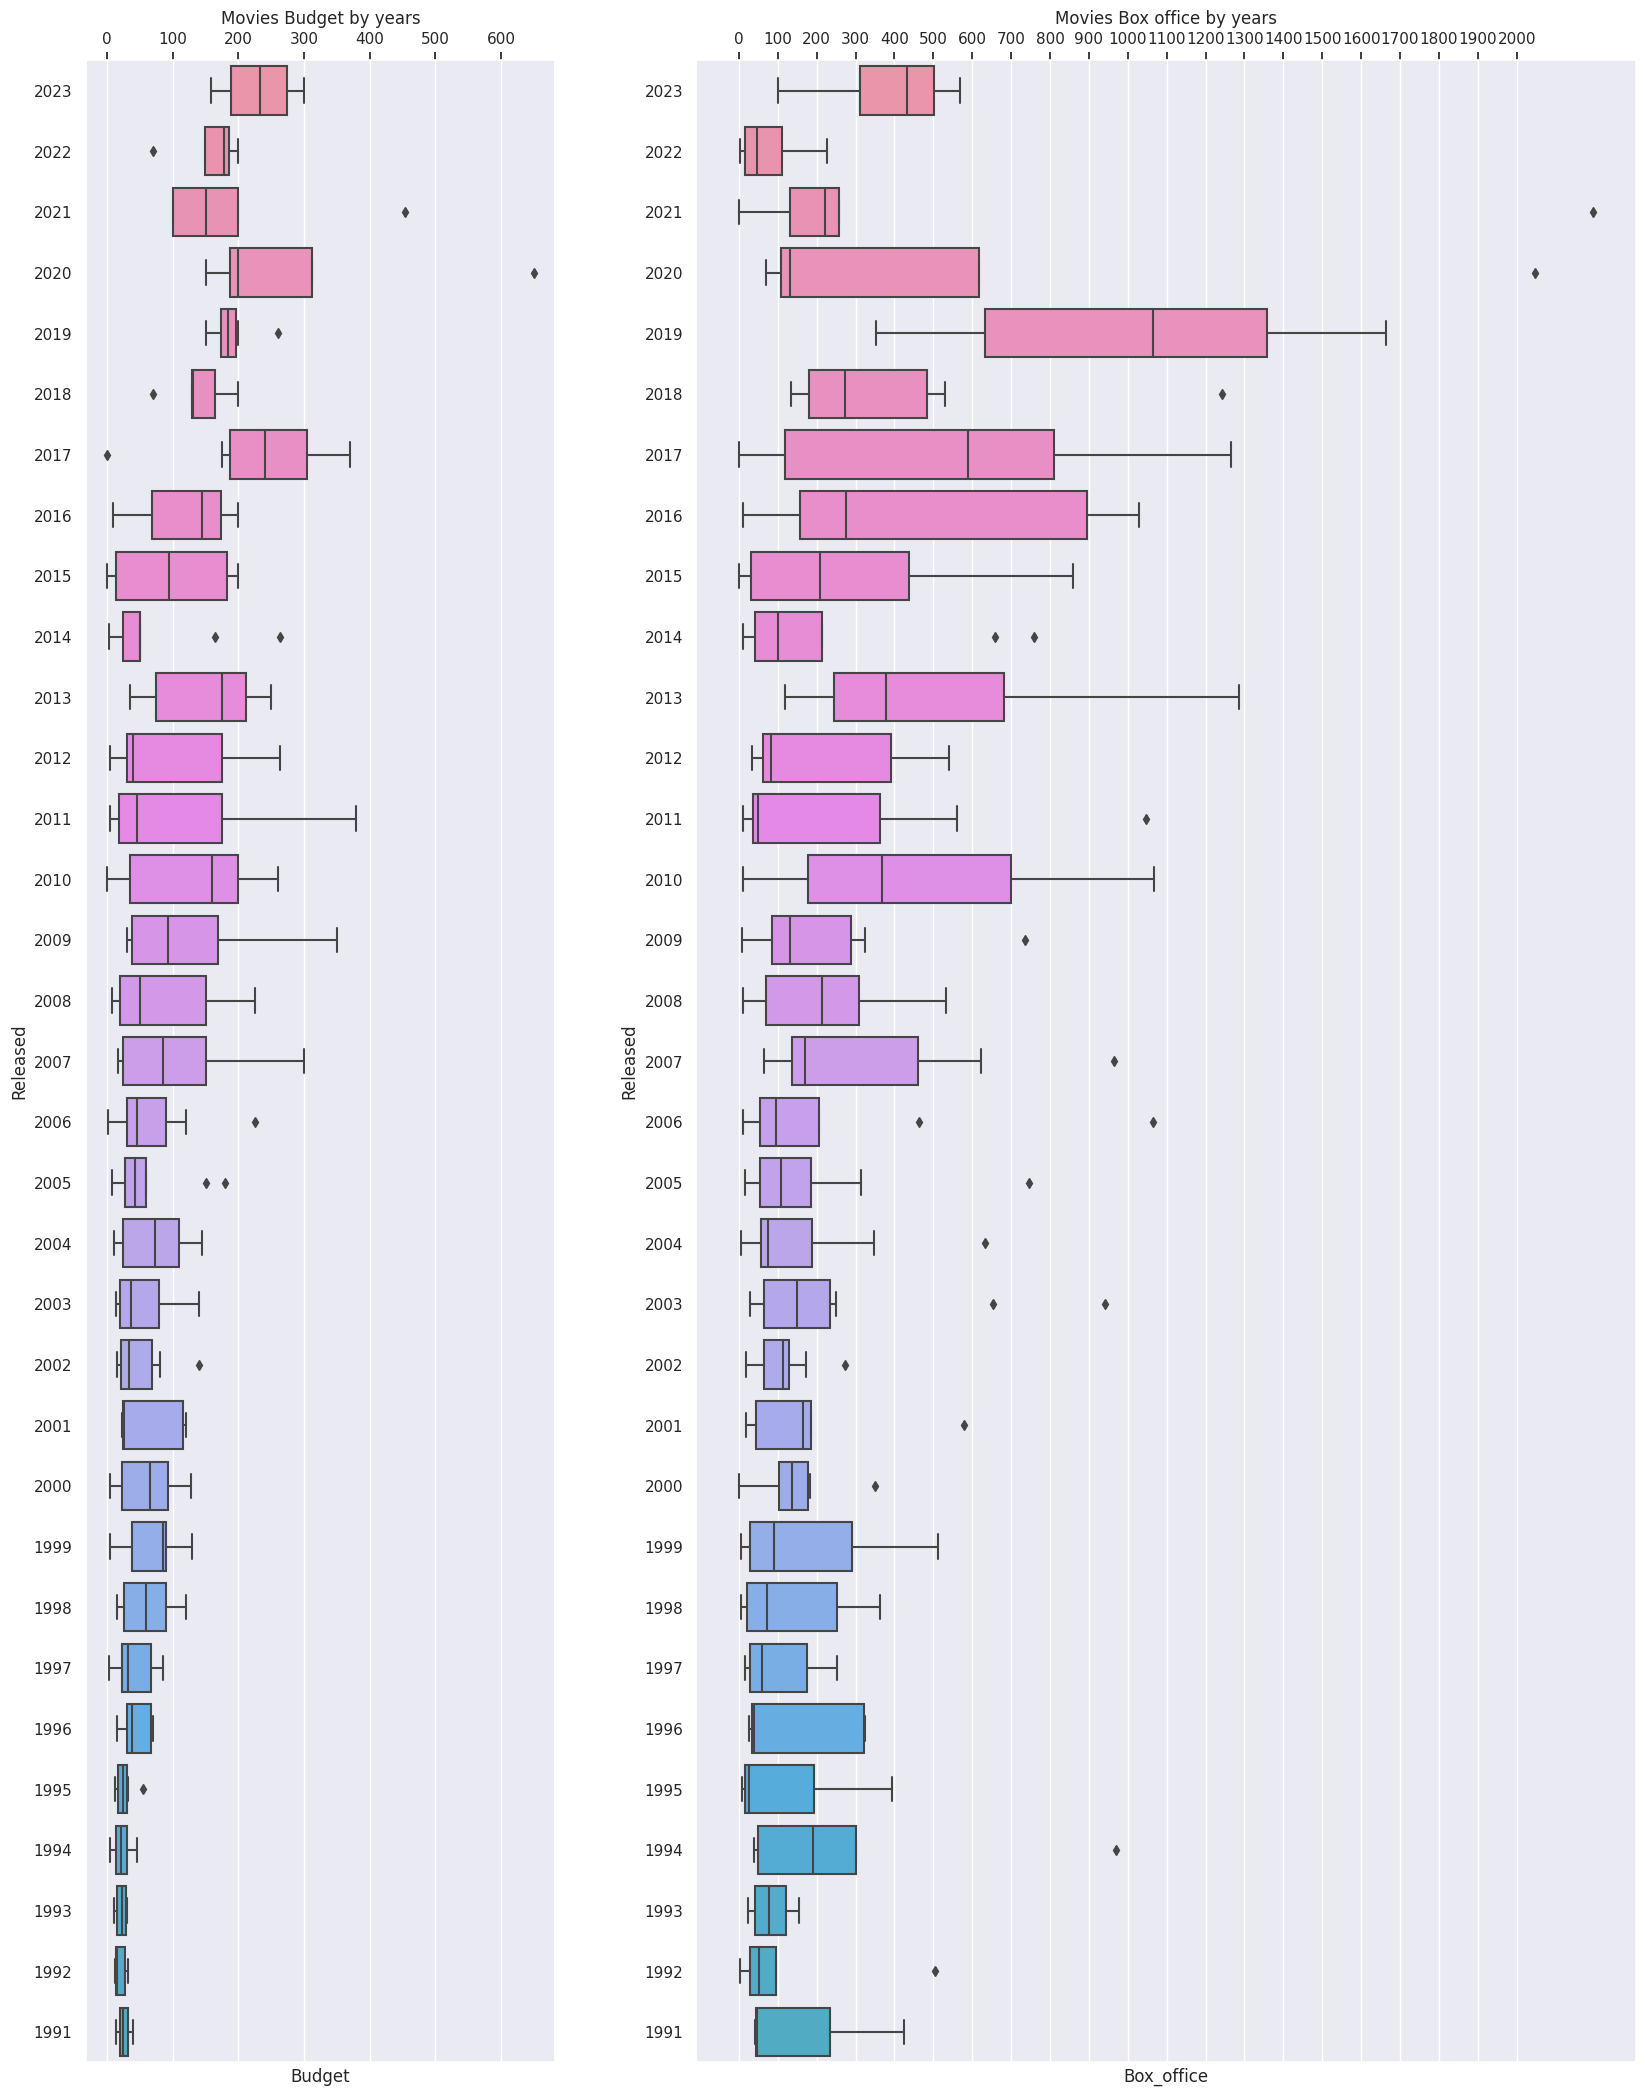

In [39]:
# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(20, 26), gridspec_kw={'width_ratios': [1, 2]})

# Create budget boxplot 
sns.boxplot(data=viz, x='Budget', y=df['Released'].dt.year, orient='h', ax=ax[0])

# Configure the plot
ax[0].set_ylim(top=49.5)
ax[0].invert_yaxis()
ax[0].set_title('Movies Budget by years')
ax[0].xaxis.tick_top()

# Create box office plot
sns.boxplot(data=viz, x='Box_office', y=df['Released'].dt.year, orient='h', ax=ax[1])

# Configure the plot
ax[1].set_ylim(top=49.5)
ax[1].invert_yaxis()
ax[1].set_title('Movies Box office by years')
ax[1].set_xticks(ticks=np.arange(0, 2001, 100))
ax[1].xaxis.tick_top()

# Display the plots
plt.show()

* As the time flies budget and box office are both raise.
* Also it is a pronounced drop in budget and box office in 2014 and drop in box office in 2020-2022.
* Drop in 2020-2022 should be due covid-19.
* I could not find any valuable reason of drop in 2014 so it might be the year of low quality movies or some other random reasons.

### Since there are extremely huge values in Budget and Box office columns i decided to exclude 5% from both sides so the calculations won't be skewed

In [40]:
budget = viz.query("Budget > Budget.quantile(0.05) and Budget < Budget.quantile(0.95)").groupby(viz['Released'].dt.year)['Budget'].agg('mean')
budget.tail()

Released
2019    177.600000
2020    183.333333
2021    137.500000
2022    156.250000
2023    178.900000
Name: Budget, dtype: float64

In [41]:
box_office = viz.query("Box_office > Box_office.quantile(0.05) and Box_office < Box_office.quantile(0.95)").groupby(viz['Released'].dt.year)['Box_office'].agg('mean')
box_office.tail()

Released
2019    422.500000
2020    110.966667
2021    202.700000
2022    106.700000
2023    383.250000
Name: Box_office, dtype: float64

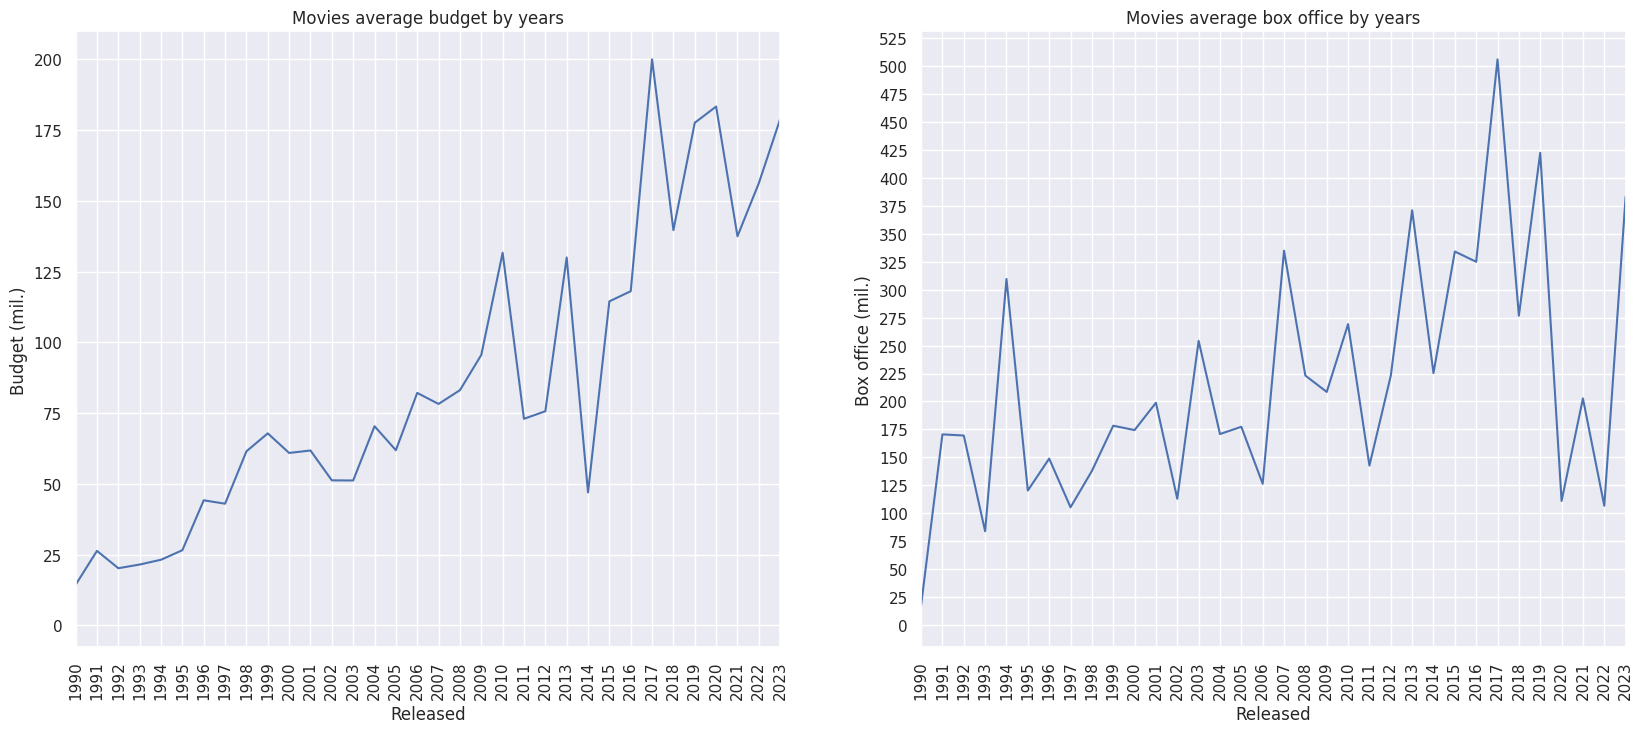

In [42]:
# Create figure and axes
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Create budget lineplot by years 
sns.lineplot(y=budget, x=budget.index, ax=ax[0])

# Configure the plot
ax[0].set_xlim(1990, 2023)
ax[0].set_xticks(ticks=np.arange(1990, 2024), labels = np.arange(1990, 2024), rotation='vertical')
ax[0].set_title('Movies average budget by years')
ax[0].set_ylabel('Budget (mil.)')

# Create box office lineplot by years
sns.lineplot(y=box_office, x=box_office.index, ax=ax[1])

# Configure the plot
ax[1].set_xlim(1990, 2023)
ax[1].set_yticks(ticks=np.arange(0, 550, 25))
ax[1].set_xticks(ticks=np.arange(1990, 2024), labels = np.arange(1990, 2024), rotation='vertical')
ax[1].set_title('Movies average box office by years')
ax[1].set_ylabel('Box office (mil.)')

# Display the plots
plt.show()

## Explore how many Disney movies were released each year starting from 1937

In [43]:
temp = df.groupby(viz['Released'].dt.year)['Title'].agg('count')
temp.head()

Released
1937.0    1
1940.0    2
1941.0    2
1942.0    1
1946.0    2
Name: Title, dtype: int64

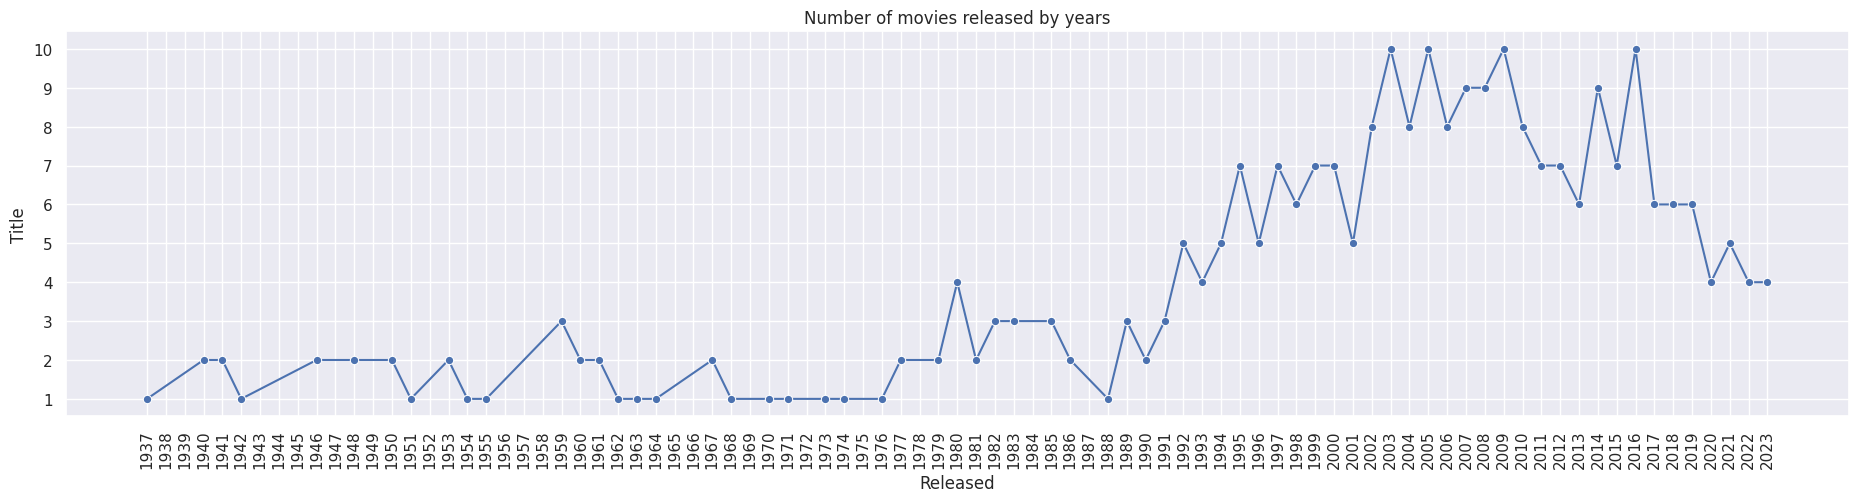

In [44]:
# Create figure
plt.figure(figsize=(23, 5))

# Create number of movies by years lineplot
sns.lineplot(x=temp.index, y=temp, marker='o')

# Configure the plot
plt.xticks(ticks=np.arange(1937, 2024, 1), rotation='vertical')
plt.yticks(ticks=np.arange(1, 11))
plt.title('Number of movies released by years')

# Display the plot
plt.show()

## Explore how many movies were released by months

In [45]:
temp = df.groupby(viz['Released'].dt.month)['Title'].agg('count')
temp

Released
1.0      9
2.0     27
3.0     24
4.0     17
5.0     29
6.0     33
7.0     28
8.0     17
9.0     10
10.0    30
11.0    37
12.0    23
Name: Title, dtype: int64

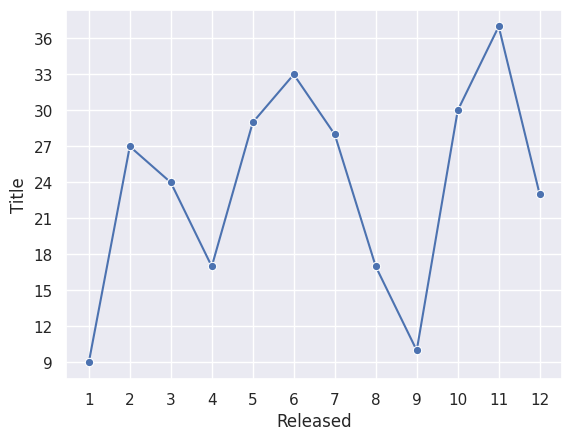

In [46]:
sns.lineplot(x=temp.index, y=temp, marker='o')
plt.yticks(ticks=np.arange(min(temp), max(temp), 3))
plt.xticks(ticks=np.arange(1, 13))
plt.show()

## Explore rated categories distribution

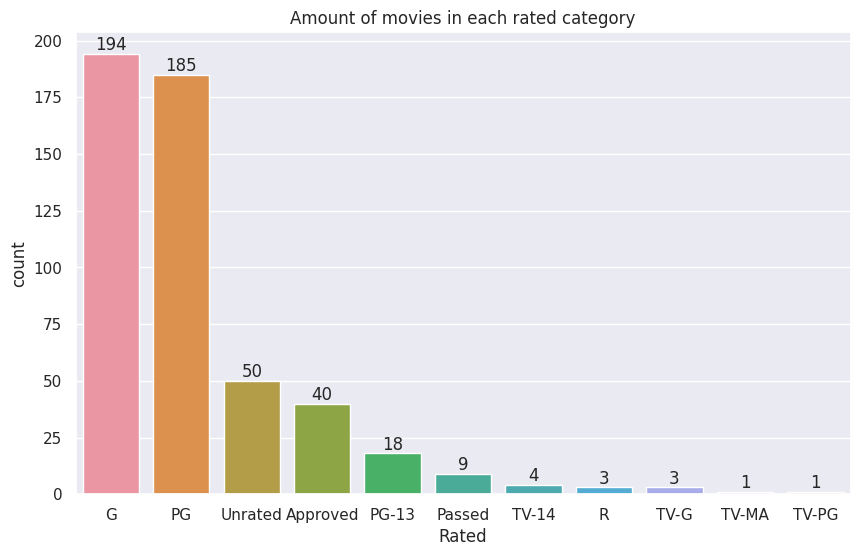

In [47]:
# Create figure
plt.figure(figsize=(10, 6))

# Create the plot 
ax = sns.countplot(x=df['Rated'], order=df['Rated'].value_counts().index)

# Configure the plot
vals = df['Rated'].value_counts().values
ax.bar_label(container=ax.containers[0], labels=vals)
plt.title('Amount of movies in each rated category')

# Display the plot
plt.show()

## Check the correlation between Budget and Box_office

In [48]:
# Compute the correlation
viz['Budget'].corr(df['Box_office'])

0.7100858717200781

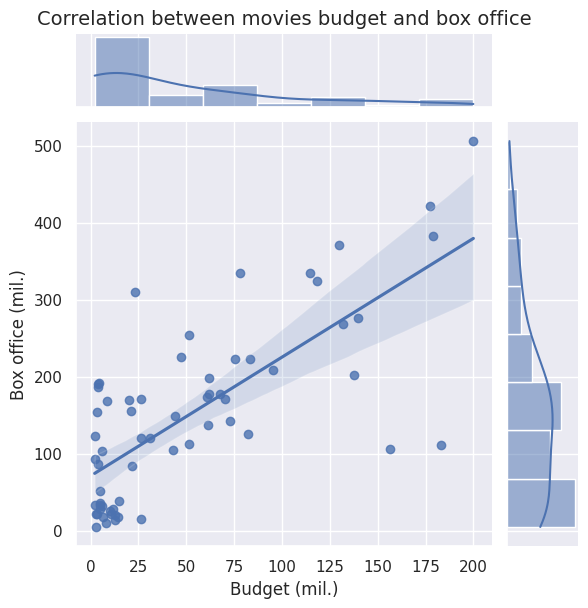

In [49]:
# Create scatterplot with linear regression line
sns.jointplot(data=viz, x=budget, y=box_office, kind='reg')

# Configure the plot
plt.title('Correlation between movies budget and box office', y=1.21, fontsize=14)
plt.xlabel('Budget (mil.)')
plt.ylabel('Box office (mil.)')

# Display the plot
plt.show()

## Make a correlation heatmap

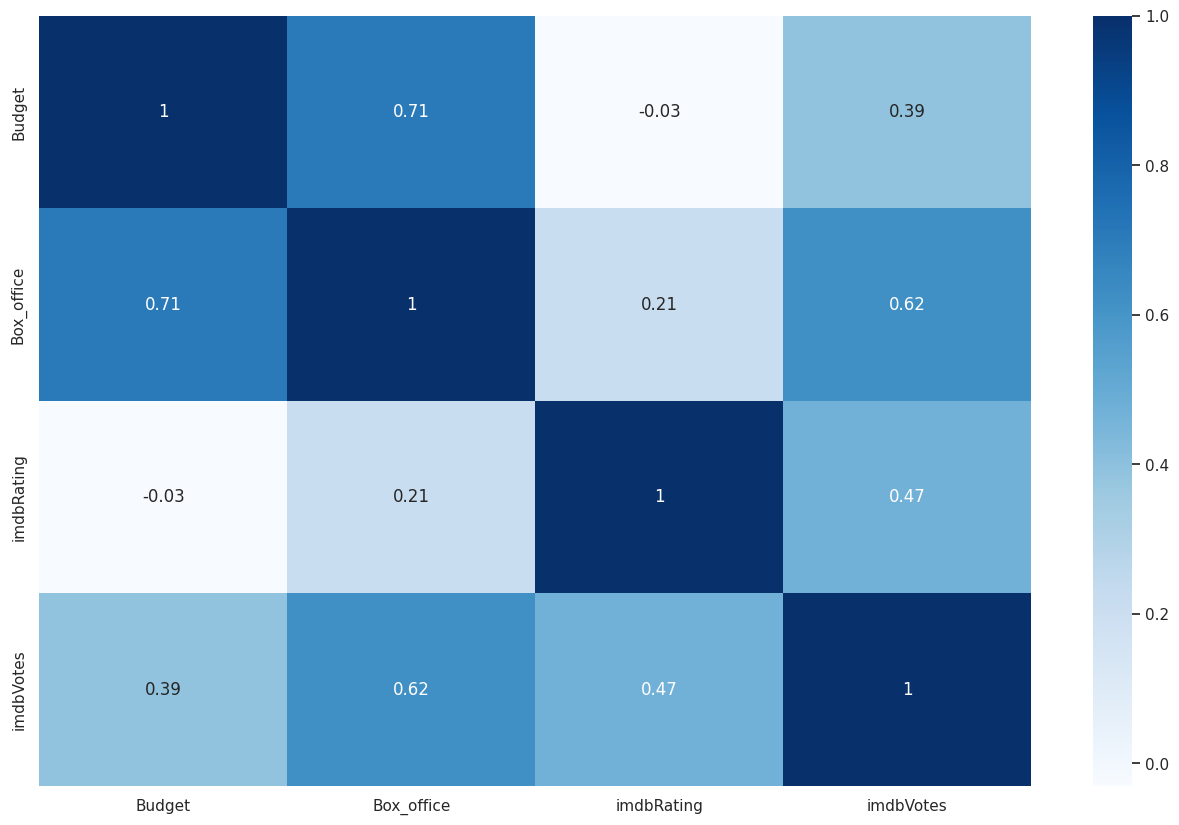

In [50]:
# Make a figure
plt.figure(figsize=(16, 10))

# Create a plot
sns.heatmap(data=viz.iloc[:, 5:9].corr(), annot=True, cmap='Blues')

# Display the plot
plt.show()